# Exploring annotated variants across tumor samples

The script will output visualizations exploring the relationship between deleterious predictions (SIFT scores) and population allele frequency (gnomAD minor allele frequency).

There are two sets of figures visualized.

1. SIFT/gnomAD across four technical replicates for all samples
2. SIFT/gnomAD for concatenated samples pre- and post filtration (filtered common variation and low read depth)

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
# Load Phenotype Data
phenotype_file = 'pdx_phenotype.csv'
phenotype_df = pd.read_table(phenotype_file, sep=',')
phenotype_df.head(2)

,sample,pt,pool,read_id,wes_id,extract,location,passage,tumor,date,ln2,rna,pedigree
0,KS1,1,2,001-F0_S3_L001_R1_001,001-F0_S3_L001_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0
1,KS1,1,2,001-F0_S3_L001_R2_001,001-F0_S3_L001_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0


## Across four technical replicates

/home/gway/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


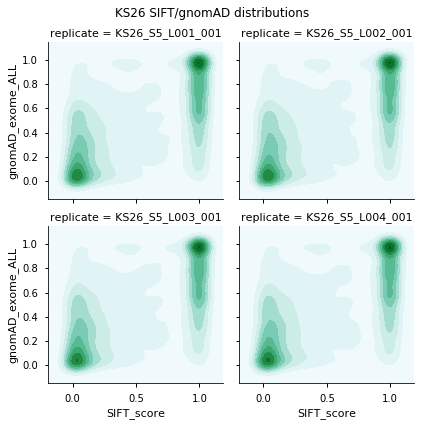

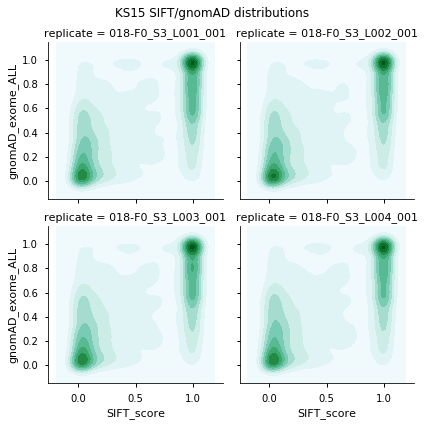

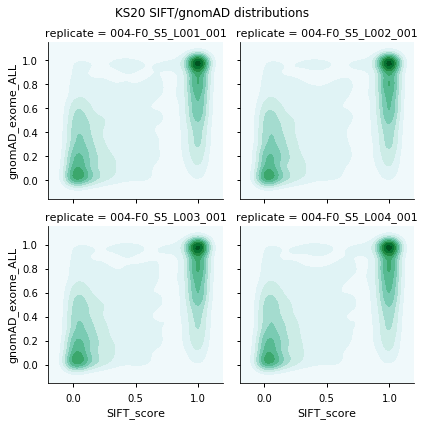

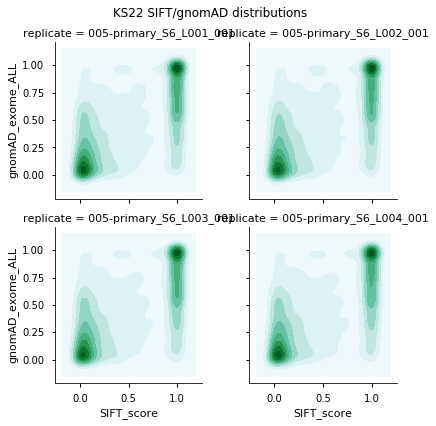

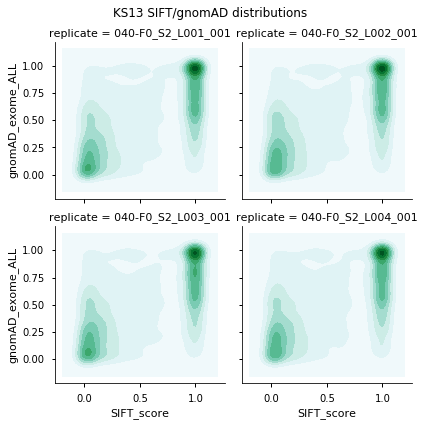

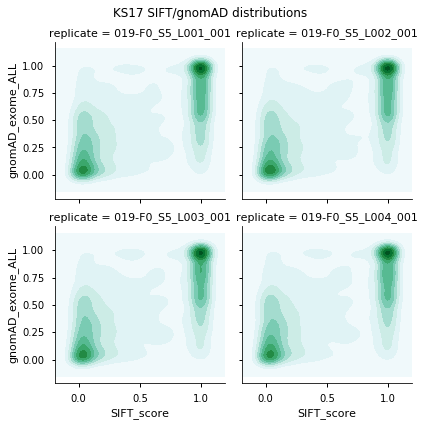

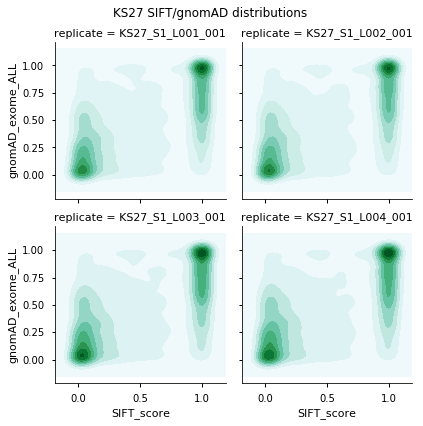

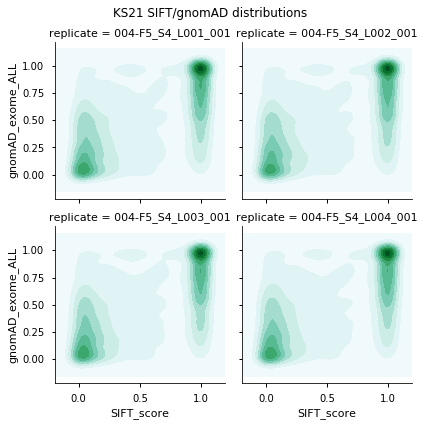

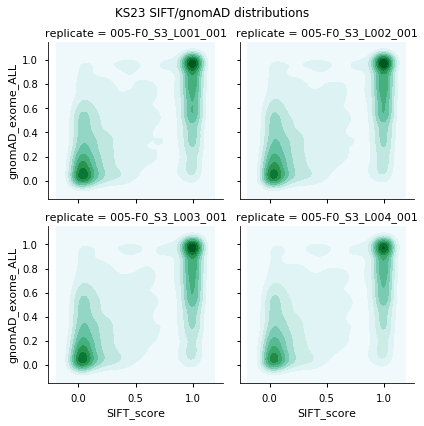

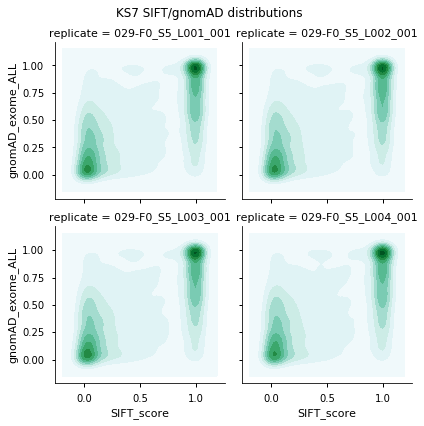

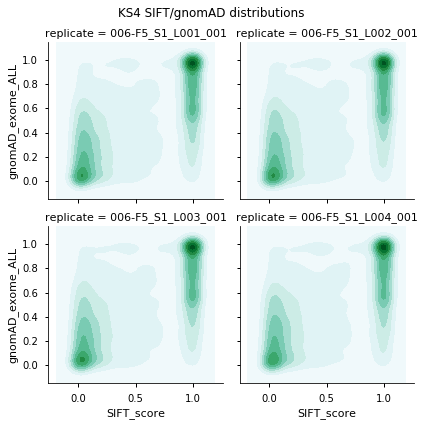

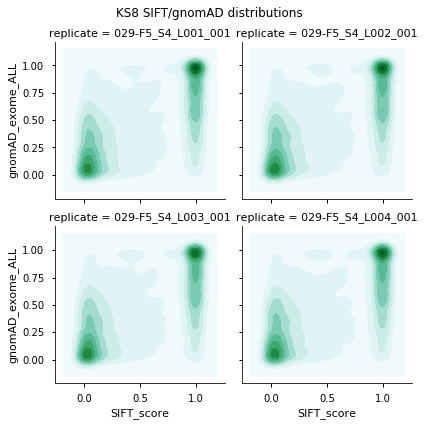

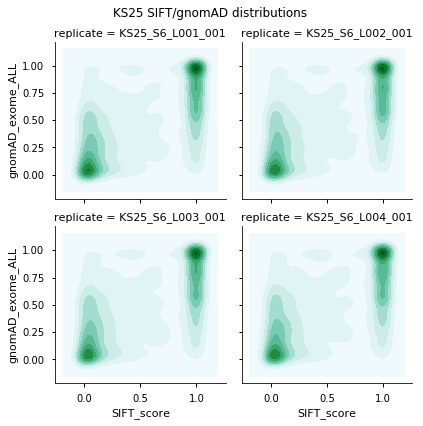

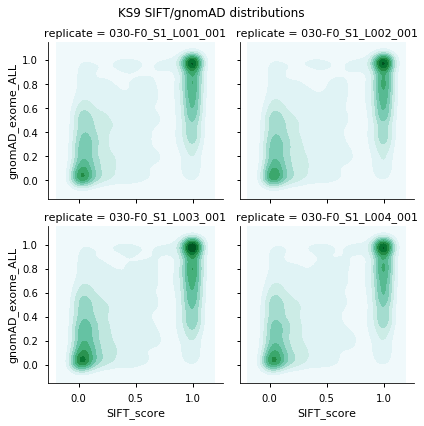

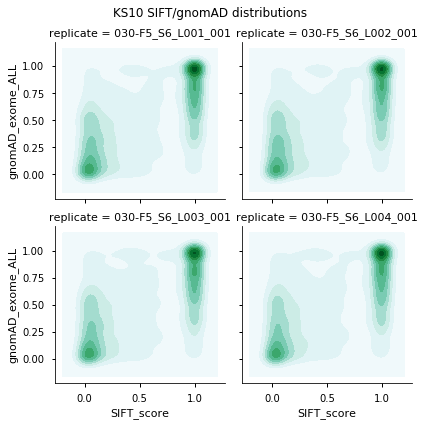

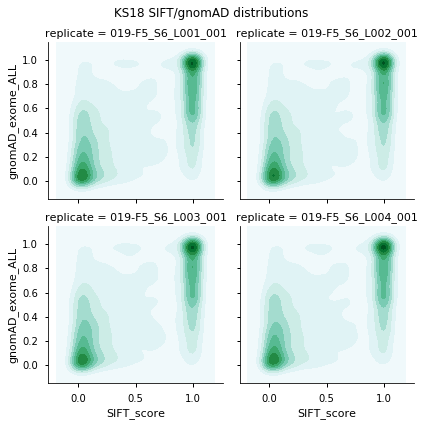

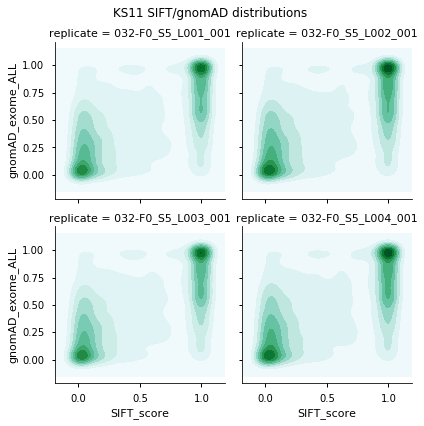

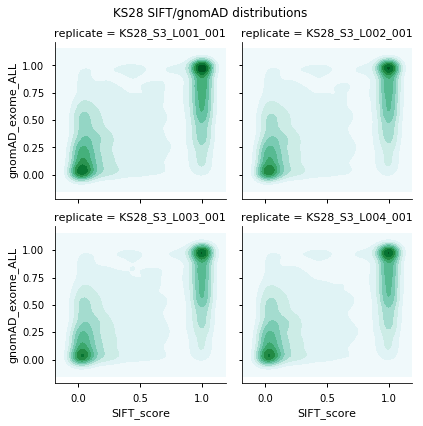

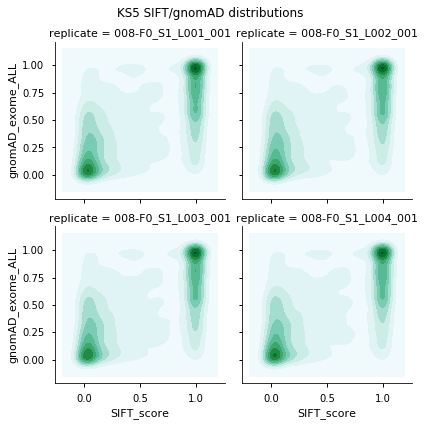

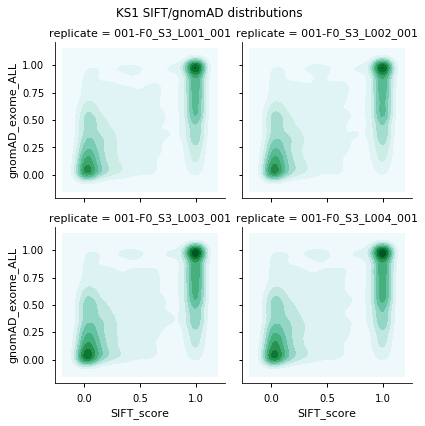

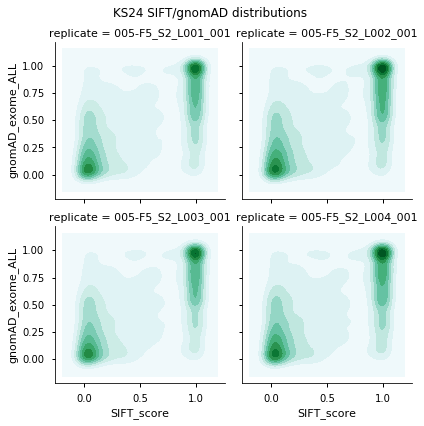

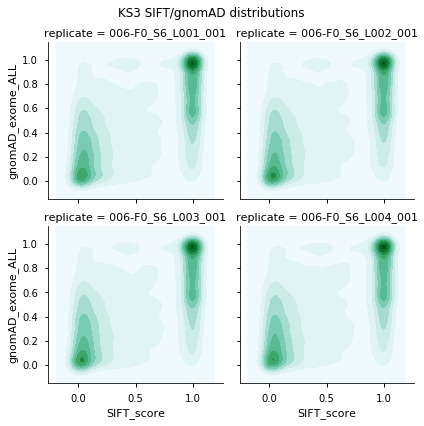

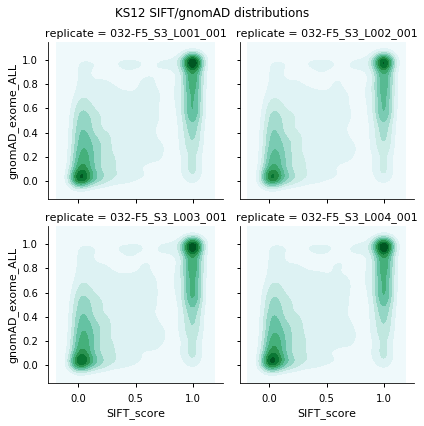

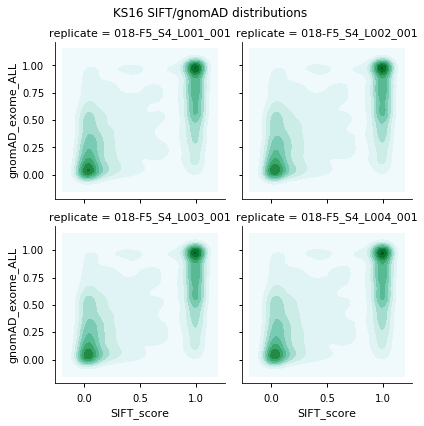

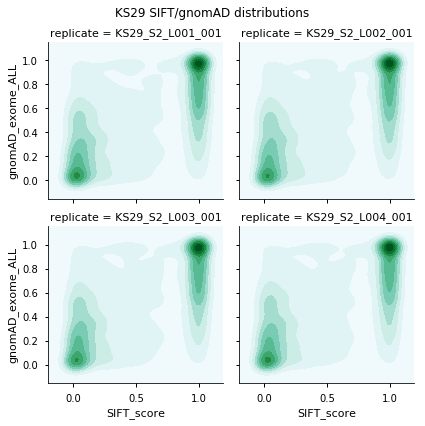

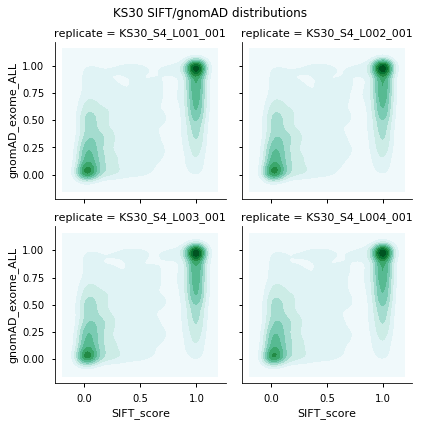

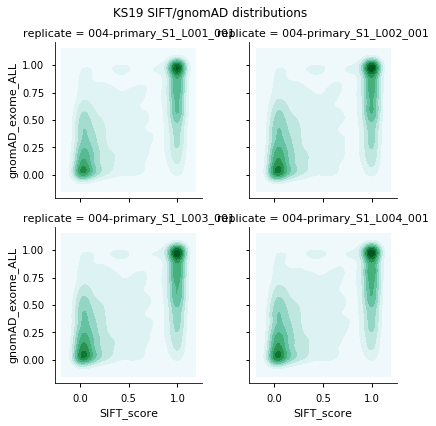

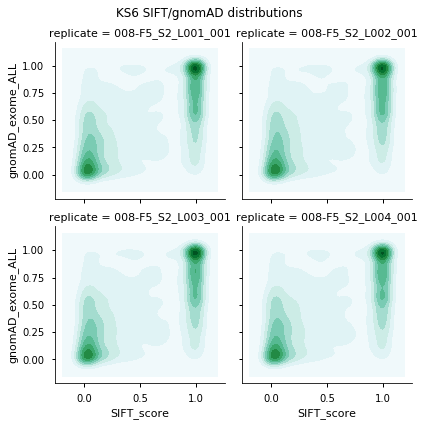

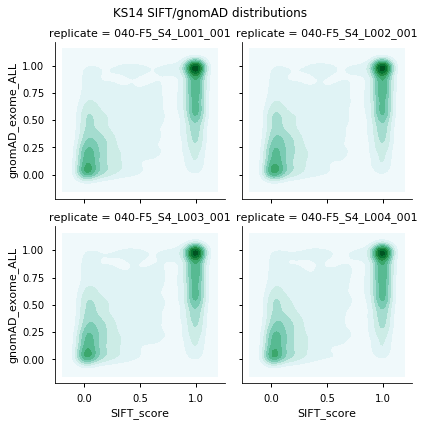

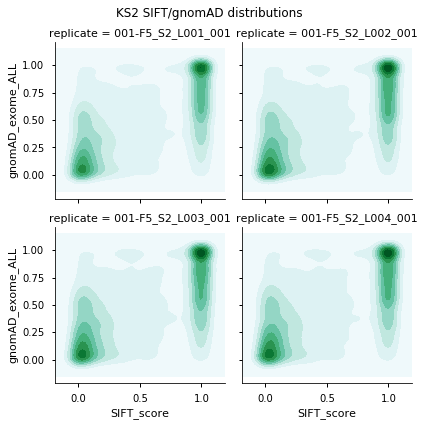

In [4]:
# Plot per replicate variants gnomAD vs. SIFT scores
for unique_sample in set(phenotype_df['sample']):
    phenotype_subset_df = phenotype_df.query('sample == @unique_sample')
    
    # generate filenames for each unique sample
    fig_name = os.path.join('figures', 'sift_gnomad', 'replicates',
                            '{}_sift_gnomad_kde.pdf'.format(unique_sample))
    multi_plots = []
    for wes_id in phenotype_subset_df['wes_id']:
        variant_file = os.path.join('results', 'annotated_vcfs',
                                    '{}.annotated.hg19_multianno.csv'.format(wes_id))
        
        variant_df = pd.read_csv(variant_file)
        variant_df = variant_df.assign(replicate = wes_id)

        # Subset variants
        filtered_variant_df = variant_df.query('SIFT_score != "."')
        filtered_variant_df = filtered_variant_df.query('gnomAD_exome_ALL != "."')
        multi_plots.append(filtered_variant_df)
        
    sample_results = pd.concat(multi_plots)
    g = sns.FacetGrid(sample_results, col='replicate', col_wrap=2)
    g = g.map(sns.kdeplot, 'SIFT_score', 'gnomAD_exome_ALL', shade=True)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('{} SIFT/gnomAD distributions'.format(unique_sample))
    plt.savefig(fig_name)
    plt.show()

## Pre- and post filtering of concatenated samples

In [5]:
sample_ids = set()
for unique_sample in set(phenotype_df['read_id']):
    unique_sample = unique_sample.split('_')[0]
    sample_ids.add(unique_sample)

/home/gway/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


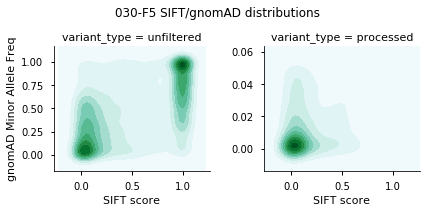

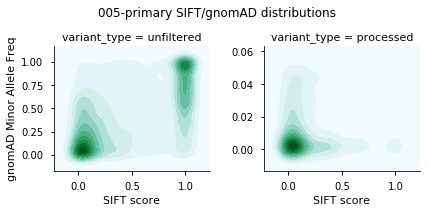

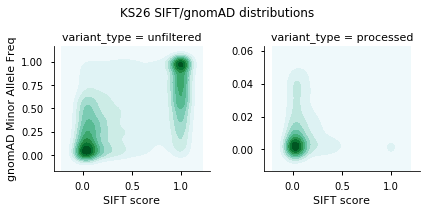

/home/gway/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


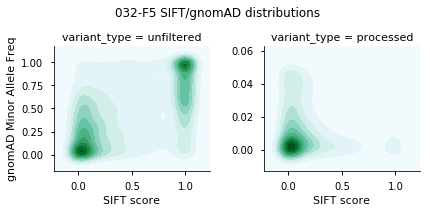

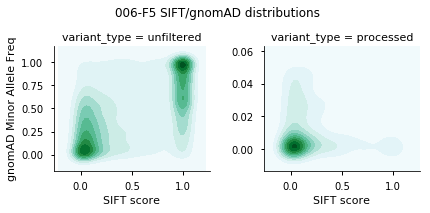

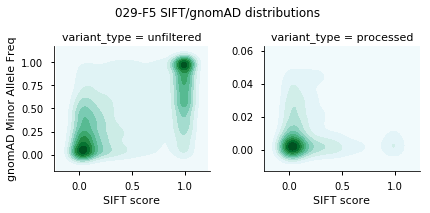

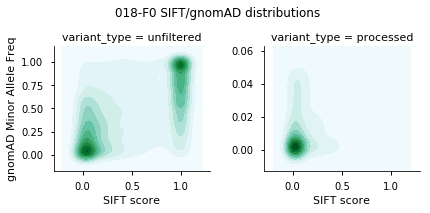

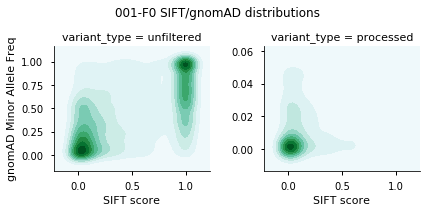

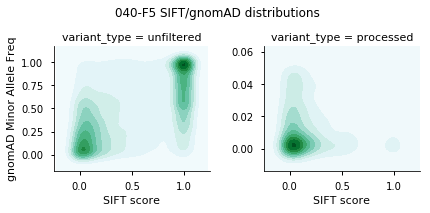

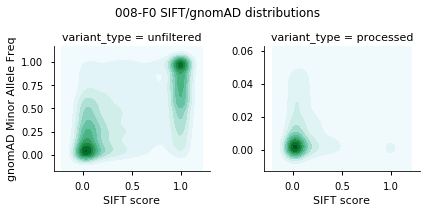

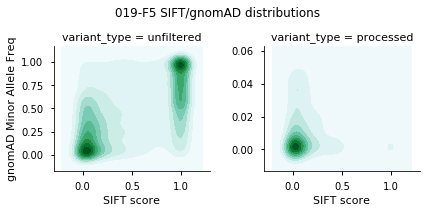

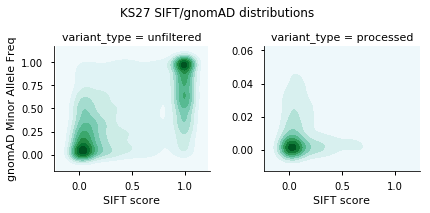

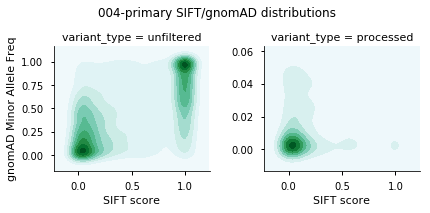

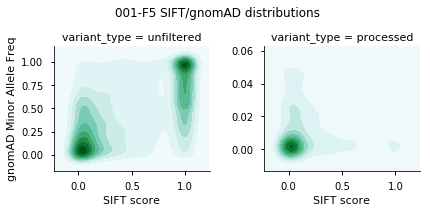

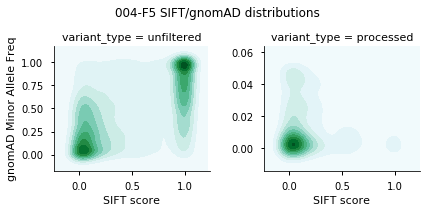

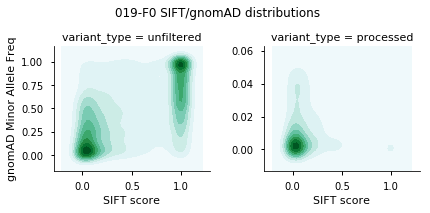

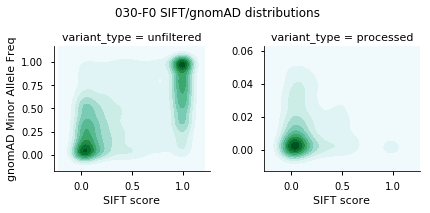

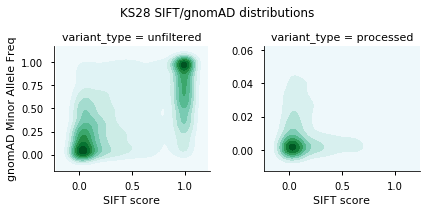

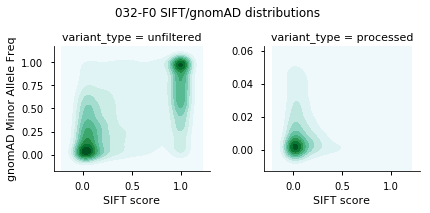

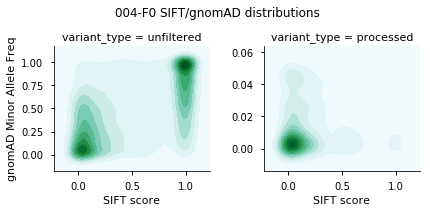

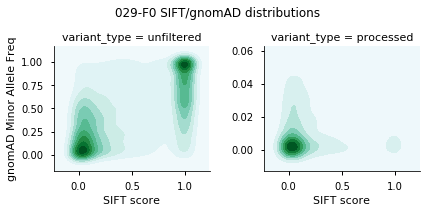

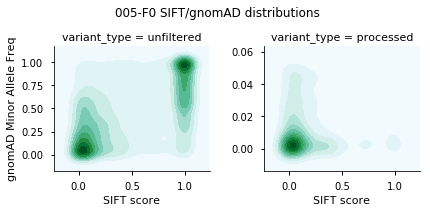

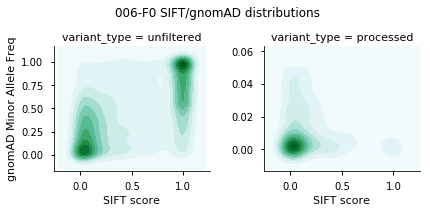

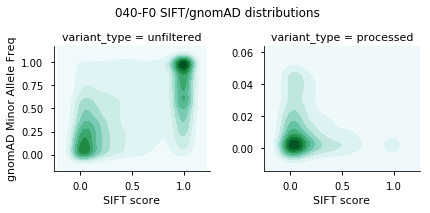

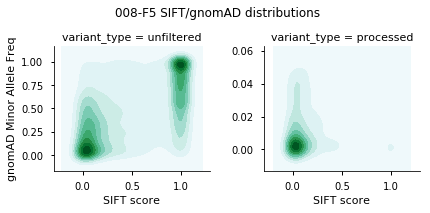

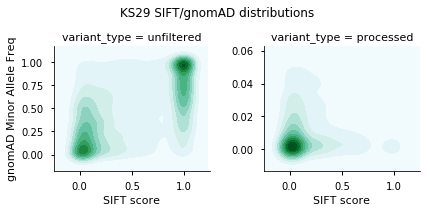

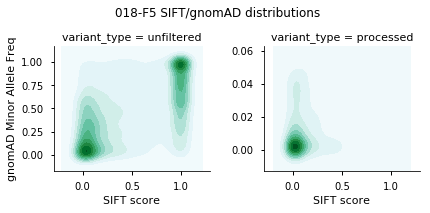

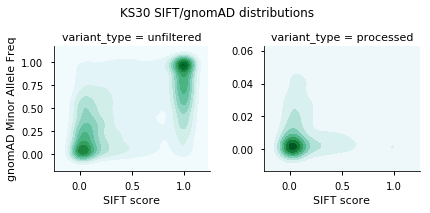

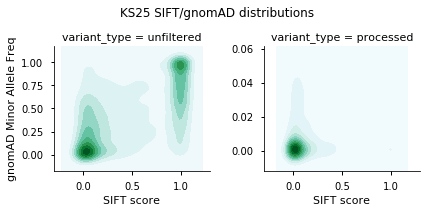

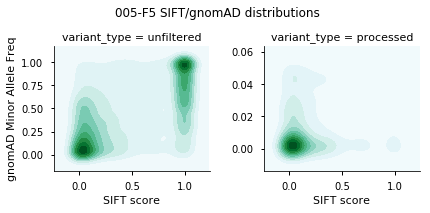

In [6]:
# Plot concatenated variants gnomAD vs. SIFT scores
for unique_sample in sample_ids:
    unique_sample = unique_sample.split('_')[0]
    
    # generate filenames for each unique sample
    fig_name = os.path.join('figures', 'sift_gnomad',
                            'merged_{}_sift_gnomad_kde.pdf'.format(unique_sample))

    # Read in file
    variant_file = os.path.join('results', 'annotated_merged_vcfs',
                                '{}.annotated.hg19_multianno.csv'.format(unique_sample))
    variant_df = pd.read_csv(variant_file)

    processed_variant_file = os.path.join('results', 'processed_merged_vcfs',
                                '{}_processed_variants.tsv.bz2'.format(unique_sample))
    processed_variant_df = pd.read_table(processed_variant_file)

    # Subset variants
    filtered_variant_df = variant_df.query('SIFT_score != "."')
    filtered_variant_df = filtered_variant_df.query('gnomAD_exome_ALL != "."')
    filtered_variant_df = filtered_variant_df.assign(variant_type='unfiltered')

    processed_variant_df = processed_variant_df.query('SIFT_score != "."')
    processed_variant_df = processed_variant_df.query('gnomAD_exome_ALL != "."')
    processed_variant_df = processed_variant_df.assign(variant_type='processed')
    
    variant_full_df = pd.concat([filtered_variant_df, processed_variant_df], axis=0)

    g = sns.FacetGrid(variant_full_df, col='variant_type', col_wrap=2, sharey=False)
    g = g.map(sns.kdeplot, 'SIFT_score', 'gnomAD_exome_ALL', shade=True)
    g.axes[0].set_xlabel("SIFT score")
    g.axes[0].set_ylabel("gnomAD Minor Allele Freq")
    g.axes[1].set_xlabel("SIFT score")
    plt.subplots_adjust(top=0.8)

    g.fig.suptitle('{} SIFT/gnomAD distributions'.format(unique_sample))
    plt.savefig(fig_name)
    plt.show()